## Project Milestone 4 - Linguistic Harbingers of Betrayal Extension Part II

In this part, we consider each game as individual, for each game, we extract four seasons right before the end of friendship, we consider the features value of the four seasons and use the data for four season as training data, we hope to increase the accuracy of the betrayal prediction.

Based on the feature selection we did, variables we consider for each season:

1. sent_pos: Positive sentiment
2. sent_neu: Neutral sentiment
3. sent_neg: Negative sentiment
4. discourse_comp: Discourse complexity (calculated through comparison, contingency, expansive, sum those values)
5. plan: Planning level (calculated through future)
6. argu_claim: Argumentation level calculated through claim
7. argu_premise: Argumentation level calculated through premise
8. n_request: Number of requests
9. politeness: Politeness
10. n_words: Number of words
11. n_sentences: Number of sentences

First, input all the libraries we need to get the plot:

In [1]:
import json
from scipy.stats import sem
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import networkx as nx
import math
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

Since the data file contains only the selected games, there is no need to consider the selection criteria when retreving the message data. 
*The condition "relationships that contain at least two consecutive and reciprocated acts of support that span at least three seasons in game time, with no more than five seasons passing between two acts of friendship" is fullfilled.

Here, we read the data from json file and get the number of games, which is 500, including 250 selected games ended up betrayal and 250 selected games ended up lasting friendship between two players.


In [2]:
# read data from diplomacy_data.json with reading mode
with open("diplomacy_data.json", "r") as f:
        data = json.load(f)
len(data)

500

Since we only consider dialogs that happen before the last act of friendship, we need to know when does the last act of friendship happen. Later when extracting feature values, extract them from the seasons that is before the last support season.

In [3]:
# a function to get the season where the last support between two players happened
# entry refer to one entry in the dataset, one game
def last_support(entry):
    seasons = entry['seasons']
    last_support = None
    for season in seasons[:-1]:
        if 'support' in season['interaction'].values():
            last_support = season['season']
    return last_support

In [4]:
# a function to get the average value across the seasons for all features of the messages
# msgs: messages sent by a player from a season in a game
def extract_features(msgs):
    n_sents = sum(m['n_sentences'] for m in msgs) * 1.0
    if(n_sents==0.0):
        print(msgs)
    
    # Sentiment
    # compute positive sentiment score
    sent_pos = sum(m['sentiment'].get("positive") for m in msgs) / len(msgs)
    # compute neutral sentiment score
    sent_neu = sum(m['sentiment'].get("neutral") for m in msgs) / len(msgs)
    # compute positive sentiment score
    sent_neg = sum(m['sentiment'].get("negative") for m in msgs) / len(msgs)
    
    # Argumentation and Discourse
    # compute discourse complexity through comparison, contingency, expansive and temporal
    comparison = sum(len(m['lexicon_words'].get("disc_comparison", []))for m in msgs) / n_sents
    contingency = sum(len(m['lexicon_words'].get("disc_contingency", []))for m in msgs) / n_sents
    expansive = sum(len(m['lexicon_words'].get("disc_expansion", []))for m in msgs) / n_sents
    discourse_comp = comparison+contingency+expansive
    
    # compute the average number of markers refer to future
    plan = sum(len(m['lexicon_words'].get("disc_temporal_future", []))for m in msgs) / n_sents
    
    # compute argumentation level through claim and premise
    argu_claim = sum(len(m['lexicon_words'].get("claim", []))for m in msgs) / n_sents
    argu_premise = sum(len(m['lexicon_words'].get("premise", []))for m in msgs) / n_sents
    
    # compute average number of request
    n_request = sum(m['n_requests'] for m in msgs) / len(msgs)
    
    # Politeness
    politeness = sum(m['politeness'] for m in msgs) / len(msgs)
    
    # Talkativeness
    # compute average number of words
    n_words = sum(m['n_words'] for m in msgs) / len(msgs)
    # compute average number of sentences
    n_sentences = sum(m['n_sentences'] for m in msgs) / len(msgs)

    return np.array([sent_pos, sent_neu, sent_neg, discourse_comp, plan, argu_claim, argu_premise, n_request, politeness, n_words, n_sentences])

In [5]:
# a function to get average politeness scores from dataset entries 
# data: the dataset where we extract politeness score from
# betrayal: if the games we consider end up betrayal
# betrayer: if the person to be analyzed is the (potential) betrayer
def process_data(data, betrayal, betrayer):
    results = []

    # loop in every game in data
    for entry in data:
        len_seasons = len(entry['seasons'])                   
        # a matrix to store features of different seasons of one game
        data41game = np.zeros((len_seasons, 11))
        cut_ind = 0
        # none is used to check if the season contain any valuable msg
        none = True
                        
        if(entry['betrayal'] == betrayal):
            for i, season in enumerate(entry['seasons']):
                if(season['season'] <= last_support(entry)):
                    if(len(season['messages']['betrayer']) > 0 and len(season['messages']['victim']) > 0):                
                        if(betrayer):
                            none = False
                            data41game[i,:] = extract_features(season['messages']['betrayer'])
                        else:
                            none = False
                            data41game[i,:] = extract_features(season['messages']['victim'])
                else:
                    cut_ind = i
                    break
        
        # we consider only games where friendship lasts for at least four season
        if(cut_ind>4):
            # save only the four seasons before the last support
            data41game = data41game[cut_ind-4:cut_ind,:]

            if(none==False):
                data41game = data41game.flat
                results.append(data41game)        

    # return value is a list of features in four seasons of the indicated player in the indicated type of games
    return results

Get the politeness score of the four conditions below:

In [6]:
# for the games end up betrayal, get politeness score for each betrayer
betray_er = pd.DataFrame(process_data(data, True, True))

# for the games end up betrayal, get politeness score for each victim
betray_vi = pd.DataFrame(process_data(data, True, False)) 

# for the games not end up betrayal, get politeness score for each potential betrayer
control_er = pd.DataFrame(process_data(data, False, True))

# for the games not end up betrayal, get politeness score for each potential victim
control_vi = pd.DataFrame(process_data(data, False, False)) 

In [7]:
betray_er['betray'] = 1
betray_vi['betray'] = 1
control_er['betray'] = 0
control_vi['betray'] = 0

frames = [betray_er,control_er,betray_vi,control_vi]
Total = pd.concat(frames,ignore_index=True)
Total = Total.rename(columns={0: "sent_pos1", 1: "sent_neu1", 2: "sent_neg1", 3: "discourse_comp1", 4: "plan1", 5: "argu_claim1", 6: "argu_premise1", 7: "n_request1", 8: "politeness1", 9: "n_words1", 10:"n_sentences1",
                                   11: "sent_pos2", 12: "sent_neu2", 13: "sent_neg2", 14: "discourse_comp2", 15: "plan2", 16: "argu_claim2", 17: "argu_premise2", 18: "n_request2", 19: "politeness2", 20: "n_words2", 21:"n_sentences2",
                                   22: "sent_pos3", 23: "sent_neu3", 24: "sent_neg3", 25: "discourse_comp3", 26: "plan3", 27: "argu_claim3", 28: "argu_premise3", 29: "n_request3", 30: "politeness3", 31: "n_words3", 32:"n_sentences3",
                                   33: "sent_pos4", 34: "sent_neu4", 35: "sent_neg4", 36: "discourse_comp4", 37: "plan4", 38: "argu_claim4", 39: "argu_premise4", 40: "n_request4", 41: "politeness4", 42: "n_words4", 43:"n_sentences4"})
Total.head()

,sent_pos1,sent_neu1,sent_neg1,discourse_comp1,plan1,argu_claim1,argu_premise1,n_request1,politeness1,n_words1,...,sent_neg4,discourse_comp4,plan4,argu_claim4,argu_premise4,n_request4,politeness4,n_words4,n_sentences4,betray
0,2.0,2.5,2.0,1.230769,0.307692,0.307692,0.153846,5.5,0.982703,166.5,...,1.333333,0.333333,0.0,0.000000,0.166667,1.333333,0.761101,35.666667,2.0,1
1,2.0,3.0,4.5,0.421053,0.105263,0.052632,0.210526,4.5,0.852683,135.0,...,1.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.852749,33.000000,4.0,1
2,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.322627,26.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1
3,2.0,3.5,2.5,0.250000,0.062500,0.000000,0.125000,4.5,0.698452,80.0,...,2.000000,0.000000,0.0,0.230769,0.153846,3.500000,0.554453,50.000000,6.5,1
4,1.0,3.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.911976,32.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1


In [35]:
XI = Total.drop(['betray'],axis = 1)
yi = Total['betray']

from sklearn.preprocessing import StandardScaler
# standardizer
standardizer = StandardScaler().fit(XI)
XI_scaled = standardizer.transform(XI)

XI_train, XI_test, yi_train, yi_test = train_test_split(XI_scaled, yi, test_size=0.2, random_state=8)



Try SVC with 5-fold cross validation using the data we get:

In [36]:
sv =SVC(C=1, kernel='rbf', gamma='auto', coef0=0.0, shrinking=True, probability=False,
        decision_function_shape='ovr', break_ties=False, random_state=None)

sv_results = cross_validate(sv, XI_train, yi_train, cv=5)
np.mean(sv_results['test_score'])

0.5647115384615384

In [37]:
# fit model
sv.fit(XI_train,yi_train)
sv.score(XI_test,yi_test)

0.6219512195121951

In [38]:
prediction_yi = sv.predict(XI_test)
cm = metrics.confusion_matrix(yi_test, prediction_yi, labels=[0,1])
recall = cm[1,1]/(cm[1,0]+cm[1,1])
precision = cm[1,1]/(cm[1,1]+cm[0,1])
F1 = 2*((precision*recall)/(precision+recall))
print("recall is {:4f}, precision is {:4f}, F1 score is {:4f}.".format(recall, precision, F1))

recall is 0.439024, precision is 0.692308, F1 score is 0.537313.


Try random forest with 5-fold cross validation using the data we get:

In [39]:
rf= RandomForestClassifier(n_estimators=100,max_depth=18,criterion='gini')

rf_results = cross_validate(rf, XI_train, yi_train, cv=5)
np.mean(rf_results['test_score'])

0.5895673076923077

In [40]:
# fit model
rf.fit(XI_train,yi_train)
rf.score(XI_test,yi_test)

0.524390243902439

In [41]:
prediction_yi = rf.predict(XI_test)
cm = metrics.confusion_matrix(yi_test, prediction_yi, labels=[0,1])
recall = cm[1,1]/(cm[1,0]+cm[1,1])
precision = cm[1,1]/(cm[1,1]+cm[0,1])
F1 = 2*((precision*recall)/(precision+recall))
print("recall is {:4f}, precision is {:4f}, F1 score is {:4f}.".format(recall, precision, F1))

recall is 0.317073, precision is 0.541667, F1 score is 0.400000.


The two models above are those with performance comparable with the model mentioned in paper. More details about our model is in our report.

We also try unsupervised method, k-means, but it does not work well:

In [15]:
# reduce dimension of the samples
from sklearn.manifold import TSNE
X_reduced_tsne = TSNE(n_components=2, random_state=0).fit_transform(XI_scaled)

print("The features of the first sample are: %s" % X_reduced_tsne[0])

The features of the first sample are: [-10.4001      4.0115457]


In [16]:
# reduce dimension of the samples
from sklearn.decomposition import PCA
X_reduced_pca = PCA(n_components=2).fit(XI_scaled).transform(XI_scaled)

print("The features of the first sample are: %s" % X_reduced_pca[0])

The features of the first sample are: [2.85597574 3.20501963]


Text(0.5, 1.0, 'PCA')

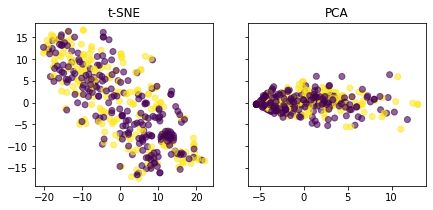

In [17]:
# visualize the samples in reduced dimension
fig, axs = plt.subplots(1, 2, figsize=(7,3), sharey=True)

# Plot the data reduced in 2d space with t-SNE
axs[0].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=Total['betray'], alpha=0.6)
axs[0].set_title("t-SNE")

# Plot the data reduced in 2d space with PCA
axs[1].scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=Total['betray'], alpha=0.6)
axs[1].set_title("PCA")

Text(0.5, 1.0, 'Discovered clusters-PCA')

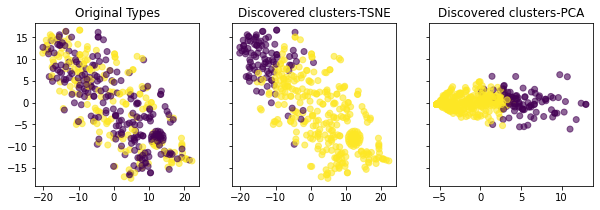

In [18]:
from sklearn.cluster import KMeans, DBSCAN

fig, axs = plt.subplots(1, 3, figsize=(10,3), sharey=True)

axs[0].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=Total['betray'], alpha=0.6)
axs[0].set_title("Original Types")

labels = KMeans(n_clusters=2, random_state=0).fit_predict(XI)

axs[1].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=labels, alpha=0.6)
axs[1].set_title("Discovered clusters-TSNE")

axs[2].scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=labels, alpha=0.6)
axs[2].set_title("Discovered clusters-PCA")

K-means does not give a desired prediction. As the samples do not cluster.